# Рекомендация тарифов

В распоряжении данные о поведении клиентов мобильного оператора, которые уже перешли на тариф. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Необходимо построить модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

### Описание данных

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
df.head(20)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


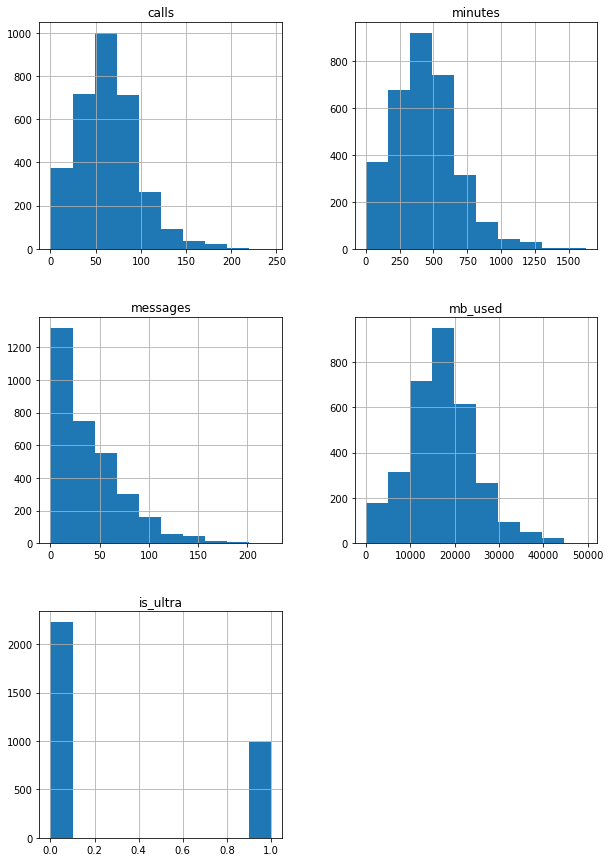

In [5]:
df.hist(figsize=(10, 15));

Какие-то аномалии и выбросы не замечены.

In [6]:
# Подсчёт пустых значений

df.isnull().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [7]:
# Вывод количества строк-дубликатов в данных

df.duplicated().sum()

0

In [8]:
# Создадим переменные с признаками и целевым признаком

features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [9]:
# Разделим выборку в соотношении 3:1:1 на обучающуюю и объединенную валидационную и тестовую

features_train, features_sample, target_train, target_sample = train_test_split(features, target,
                                                                              test_size=0.4, random_state=12345)

In [10]:
# Разделим временную выборку на валидационную и тестовую

features_valid, features_test, target_valid, target_test = train_test_split(features_sample, target_sample,
                                                                              test_size=0.5, random_state=12345)

In [11]:
print("Размер генеральной совокупности:", df.shape[0])
print("Размер обучающей выборки:", features_train.shape[0])
print("Размер валидационной выборки:", features_valid.shape[0])
print("Размер тестовой выборки:", features_test.shape[0])

Размер генеральной совокупности: 3214
Размер обучающей выборки: 1928
Размер валидационной выборки: 643
Размер тестовой выборки: 643


Мы разделили данные на обучающую, валидационную и тестовую выборки в соотношении 3:1:1, что позволит нам оценить качество модели на разных этапах и избежать переобучения. Обучающая выборка содержит 1928 наблюдений, валидационная и тестовая — по 643.

Так как данные категориальные используем модели **DecisionTreeClassifier**, **RandomForestClassifier**, и **LogisticRegression.** А также метрику **accuracy score** для определения доли предсказаний.

In [12]:
best_result_dt = 0
best_depth_dt = 0

for depth in range(1, 6):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train)
    predictions_valid_dt = model_dt.predict(features_valid)
    accuracy_dt = accuracy_score(target_valid, predictions_valid_dt)
    
    if accuracy_dt > best_result_dt:
        best_result_dt = accuracy_dt
        best_depth_dt = depth
        
print("Accuracy модели DecisionTreeClassifier на валидационной выборке:", best_result_dt)
print("Глубина дерева:", best_depth_dt)

Accuracy модели DecisionTreeClassifier на валидационной выборке: 0.7853810264385692
Глубина дерева: 3


In [13]:
best_result_rf = 0
best_depth_rf = 0
best_est_rf = 0

for est in [10, 50, 100]:
    for depth_rf in range(5, 16, 5):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth_rf)
        model_rf.fit(features_train, target_train)
        predictions_valid_rf = model_rf.predict(features_valid)
        accuracy_rf = accuracy_score(target_valid, predictions_valid_rf)

        if accuracy_rf > best_result_rf:
            best_result_rf = accuracy_rf
            best_depth_rf = depth_rf
            best_est_rf = est
        
print("Accuracy модели DecisionTreeClassifier на валидационной выборке:", best_result_rf)
print("Количество деревьев:", best_est_rf)
print("Максимальная глубина:", depth_rf)

Accuracy модели DecisionTreeClassifier на валидационной выборке: 0.7947122861586314
Количество деревьев: 100
Максимальная глубина: 15


In [14]:
model_lr = LogisticRegression(random_state=12345)
model_lr.fit(features_train, target_train)
predictions_valid_lr = model_lr.predict(features_valid)

accuracy_lr = accuracy_score(target_valid, predictions_valid_lr)

print("Accuracy модели LogisticRegression на валидационной выборке:", accuracy_lr)

Accuracy модели LogisticRegression на валидационной выборке: 0.7107309486780715


Результаты показали, что RandomForestClassifier с 100 деревьями и максимальной глубиной 15 достиг наилучшей точности на валидационной выборке среди протестированных моделей.
DecisionTreeClassifier показал чуть меньшую точность с глубиной дерева 3.
LogisticRegression показывает наименьшую точность.

In [15]:
# Установим лучшую модель

best_model = RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=15)

## Провекрка модели на тестовой выборке

In [16]:
# Обучим модель на обучающей выборке

best_model.fit(features_train, target_train)

RandomForestClassifier(max_depth=15, random_state=12345)

In [17]:
# Получим предсказания на тестовой выборке

predictions_test = best_model.predict(features_test)

In [18]:
# Посчитаем accuracy на тестовой выборке

accuracy = accuracy_score(target_test, predictions_test)

In [19]:
print("Accuracy тестовой выборки:", accuracy)

Accuracy тестовой выборки: 0.7962674961119751


## Проверка модели на адекватность

In [20]:
# Посчитаем количество клиентов с тарифом смарт и общее количество клиентов

smart_count = df[df['is_ultra'] == 0]['is_ultra'].count()
total_count = df['is_ultra'].count()

In [21]:
# Посчитаем Accuracy для проверочной модели

check_model = smart_count / total_count

In [22]:
print("Accuracy проверочной модели (предсказывает только 'Смарт'):", check_model)

print("Accuracy модели DecisionTreeClassifier на валидационной выборке:", best_result_dt)
print("Accuracy модели RandomForestClassifier на валидационной выборке:", best_result_rf)
print("Accuracy модели LogisticRegression на валидационной выборке:", accuracy_lr)
print("Accuracy лучшей модели (RandomForestClassifier) на тестовой выборке:", accuracy)

Accuracy проверочной модели (предсказывает только 'Смарт'): 0.693528313627878
Accuracy модели DecisionTreeClassifier на валидационной выборке: 0.7853810264385692
Accuracy модели RandomForestClassifier на валидационной выборке: 0.7947122861586314
Accuracy модели LogisticRegression на валидационной выборке: 0.7107309486780715
Accuracy лучшей модели (RandomForestClassifier) на тестовой выборке: 0.7962674961119751


Accuracy обученных моделей выше чем у проверочной, это говорит о том, что модель способна различать клиентов, которым подходит один из двух тарифов.

## Общий вывод

В ходе работы была построена система классификации для выбора подходящего тарифа ("Смарт" или "Ультра") для клиентов мобильного оператора. Мы разделили данные на обучающую, валидационную и тестовую выборки для корректной оценки моделей.

Были протестированы три модели: DecisionTreeClassifier, RandomForestClassifier и LogisticRegression. Лучшую точность на валидационной выборке показала модель RandomForestClassifier с 100 деревьями и максимальной глубиной 15, достигнув accuracy 0.7947. Эта модель также продемонстрировала наивысшую точность на тестовой выборке — 0.7963.

Дополнительно была выполнена проверка на аддекватность, accuracy которой показало значение ниже чем на валидационной и тестовой, что подтверждает, что RandomForestClassifier способен качественно различать клиентов, которым подходит один из двух тарифов.